<a href="https://colab.research.google.com/github/caesarcc/python-tcc-url-fakenews-check/blob/main/jupyter/passo05_finetune_BERT_fakebr_classificacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Configuração para rodar no Goolge Colab    
O treinamento no Colab levou pouco menos de uma hora, enquanto no computador local indicou que levaria mais de 2 dias.   
As primeiras célucas devem ser executadas para instalar a arquitetura de transformers e liberar o acesso ao drive do Colab.  
O arquivo .csv de entrada pode ser enviado por upload.

In [2]:
!pip install -q transformers

     |████████████████████████████████| 4.2 MB 6.8 MB/s 
     |████████████████████████████████| 6.6 MB 61.5 MB/s 
     |████████████████████████████████| 596 kB 74.0 MB/s 
     |████████████████████████████████| 84 kB 2.6 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Treino e Avaliação do Modelo BERT em PT-BR

In [4]:
# Importação de bibliotecas utilizadas no treino e avaliação
import datetime
import random
import time
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import (accuracy_score, auc, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay, roc_curve)
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from transformers import (BertForSequenceClassification, BertTokenizer,
                          get_linear_schedule_with_warmup)
from transformers.file_utils import is_torch_available

%matplotlib inline

### Carrega dados processados no passo 1

In [5]:
PLANILHA_DATASET = r'/content/drive/MyDrive/PUC/TCC/dados/whatsappbr_corpus_processado.csv'
pd.set_option("display.max_rows", 50, 'display.max_colwidth', 200)
dados_processado = pd.read_csv(PLANILHA_DATASET, sep = ',')
dados_processado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21289 entries, 0 to 21288
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Unnamed: 0             21289 non-null  int64 
 1   texto                  21289 non-null  object
 2   classe                 21289 non-null  int64 
 3   texto_limpo            21289 non-null  object
 4   texto_processado       21289 non-null  object
 5   qtde_texto_limpo       21289 non-null  int64 
 6   qtde_texto_processado  21289 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 1.1+ MB


In [6]:
dados_processado[['classe','texto','texto_processado','qtde_texto_processado']].sample(n=3)

,classe,texto,texto_processado,qtde_texto_processado
2105,0,"Oi galera.....independente em quem vcs irão votar, não se esqueçam de:\n1. Levar uma colinha de seu candidato no BOLSO.\n2. Na zona eleitoral, entrar e JAIR votando.\n3. Não se esqueçam que a vota...","Oi galera.independente vcs ir votar , esquecer : 1 . Levar colinha candidatar BOLSO . 2 . zonar eleitoral , entrar JAIR votar . 3 . esquecer votação encerrar 17 . Anotem dica ai",36
13250,1,"Cronologia da desgraça anunciada:\n1 - Outubro: Hadad, Ciro ou Marina no segundo turno com Bolsonaro.\n\n2- Novembro: Todos contra Bolsonaro. Ganha Hadad, Ciro ou Marina.\n\n3- Dilma eleita senado...","Cronologia desgraçar anunciar : 1 Novembro : Bolsonaro . Ganha Hadad , Ciro Marina . 3 Janeiro : Dilma assumir presidência Senado , Gleisi assumir presidência Câmara . 5 Março : Lula assumir C...",73
7821,0,"Para descontrair!\n\n🤔 *Dizem que:*\n*Lula é Haddad,*\n*Haddad é Lula.*\n*O que eu sei,*\n*é que Lula tem 72 anos* \n*e Haddad tem 55 anos.*\n\n*Resumindo:*\n *72 - 55 =* 1⃣7⃣\n*A mat...","descontrair ! : Lula Haddad , Haddad Lula . , Lula 72 ano * Haddad 55 ano . Resumindo : 72 55 matemático ciência exata , chorar livrar . aguentar !",30


### Geração de seed  
Com esta rotina consigo garantir a reprodução dos resultados mesmo que o ambiente for reiniciado
Aplicável às libs random, numpy e torch

In [7]:
RANDOM_SEED = 42
def garantir_reprodutividade(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
            return "cuda"
    return "cpu"

device = garantir_reprodutividade(RANDOM_SEED)

### Carregando o modelo pré-treinado BERTimbau

In [8]:
MODELO_BERT = "/content/drive/MyDrive/PUC/TCC/modelos/bertimbau_avaliar_noticias"
model = BertForSequenceClassification.from_pretrained(MODELO_BERT, num_labels=2, output_attentions=False, output_hidden_states=False)
tokenizer = BertTokenizer.from_pretrained(MODELO_BERT, do_lower_case=False)

### Tokeniza textos

In [9]:
dados_token = dados_processado[['classe','texto_processado']].copy()
dados_token['TOKENS'] = dados_token['texto_processado'].apply(lambda x: np.array(tokenizer.encode(x, padding='max_length', truncation=True, max_length=400)))
dados_token['LABELS'] = dados_token['classe']
dados_token = dados_token[['TOKENS','LABELS']]

### Separando treino, teste e validação

In [10]:
# Divido em 70% para treino e 20% para validação e o restante para teste, fracionado aleatoriamente e com random seed 42
dados_treino, dados_validacao, dados_teste = np.split(dados_token.sample(frac=1), [int(.7*len(dados_token)), int(.8*len(dados_token))])
display(f"Treinamento: {dados_treino.shape[0]}, Teste: {dados_teste.shape[0]}, Validação: {dados_validacao.shape[0]}")

'Treinamento: 14902, Teste: 4258, Validação: 2129'

### Geração dos tensores

In [11]:
treino_valores = torch.tensor(dados_treino['TOKENS'].values.tolist()).to(torch.int64)
treino_classes = torch.tensor(np.array(dados_treino.LABELS.values)).to(torch.int64)
validacao_valores = torch.tensor(dados_validacao['TOKENS'].values.tolist()).to(torch.int64)
validacao_classes = torch.tensor(np.array(dados_validacao.LABELS.values)).to(torch.int64)
teste_valores = torch.tensor(dados_teste['TOKENS'].values.tolist()).to(torch.int64)
teste_classes = torch.tensor(np.array(dados_teste.LABELS.values)).to(torch.int64)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  """Entry point for launching an IPython kernel.


### Preparando o fine-tunning do modelo BERTimbau

In [14]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

epocas = 5
tamanho_lote = 16

# gera dataset e leitor de dados de treino
treino_dados = TensorDataset(treino_valores, treino_classes)
treino_leitor = DataLoader(treino_dados, sampler=RandomSampler(treino_dados), batch_size=tamanho_lote)
# gera dataset e leitor de dados de validação
validacao_dados = TensorDataset(validacao_valores, validacao_classes)
validacao_leitor = DataLoader(validacao_dados, sampler=SequentialSampler(validacao_dados), batch_size=tamanho_lote)

In [15]:
# coleca modelo no divice disponível (cuda para GPU)
model.to(device)

passos_total = len(treino_leitor) * epocas
# configuração do otimizador e do scheduler para controlar hyperparametros
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = passos_total)

In [16]:
estatisticas = []
inicio_total = time.time()

for epoca in range(0, epocas):
    print('\n======== Época {:} / {:} ========'.format(epoca + 1, epocas))
    print('Treinando...')
    inicio_processo = time.time()

    # Reinicia o loss a cada época
    loss_por_epoca = 0
    model.train()
    for passo, lote in enumerate(treino_leitor):
        if passo % 40 == 0 and not passo == 0:
            tempo = format_time(time.time() - inicio_processo)

            print('  Passo {:>5,}  de  {:>5,}.  Tempo decorrido: {:}.'.format(passo, len(treino_leitor), tempo))

        lote_valores = lote[0].to(device)
        lote_classes = lote[1].to(device)

        model.zero_grad()

        outputs = model(lote_valores,
                             token_type_ids=None,
                             labels=lote_classes)
        loss_por_epoca += outputs.loss.item()
        outputs.loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    # Calcula a média do loss sobre todos lotes
    loss_treino_media = loss_por_epoca / len(treino_leitor)

    tempo_por_epoca = format_time(time.time() - inicio_processo)
    print("\n  Média do loss de treino: {0:.2f}".format(loss_treino_media))
    print("  Tempo do treino: {:}".format(tempo_por_epoca))

    print("\nValidando...")
    inicio_processo = time.time()

    # Coloca o modelo em modo de validação
    model.eval()

    # reseta variáveis para validação por epoca
    validacao_acuracia_total = 0
    validacao_loss_total = 0

    for lote in validacao_leitor:

        lote_valores = lote[0].to(device)
        lote_classes = lote[1].to(device)

        with torch.no_grad():

            outputs = model(lote_valores,
                                   token_type_ids=None,
                                   labels=lote_classes)

        classes_previstas = outputs.logits.detach().cpu().numpy()
        classes = lote_classes.to('cpu').numpy()
        predicao = np.argmax(classes_previstas, axis=1).flatten()
        classes = classes.flatten()
        validacao_acuracia_total += np.sum(predicao == classes) / len(classes)

    # mostra a acurácia de cada avaliação.
    validacao_acuracia_media = validacao_acuracia_total / len(validacao_leitor)
    print("  Acurácia: {0:.2f}".format(validacao_acuracia_media))

    # calcula a média da perda nos lotes.
    validacao_loss_medio = validacao_loss_total / len(validacao_leitor)

    # mede o tempo de cada avaliação.
    validation_time = format_time(time.time() - inicio_processo)

    print("  Loss de validação: {0:.2f}".format(validacao_loss_medio))
    print("  Tempo de validação: {:}".format(validation_time))

    # grava as estatísticas por época.
    estatisticas.append(
        {
            'epoca': epoca + 1,
            'Loss de Treinamento': loss_treino_media,
            'Loss de Validação': validacao_loss_medio,
            'Acurácia de Validação': validacao_acuracia_media,
            'Tempo de Treino': tempo_por_epoca,
            'Tempo de Validação': validation_time
        }
    )
print("\nTreinamento completo!")
print("Tempo total do treino {:} (h:mm:ss)".format(format_time(time.time()-inicio_total)))


======== Época 1 / 5 ========
Treinando...
  Passo    40  de    932.  Tempo decorrido: 0:00:26.
  Passo    80  de    932.  Tempo decorrido: 0:00:51.
  Passo   120  de    932.  Tempo decorrido: 0:01:16.
  Passo   160  de    932.  Tempo decorrido: 0:01:42.
  Passo   200  de    932.  Tempo decorrido: 0:02:07.
  Passo   240  de    932.  Tempo decorrido: 0:02:32.
  Passo   280  de    932.  Tempo decorrido: 0:02:58.
  Passo   320  de    932.  Tempo decorrido: 0:03:23.
  Passo   360  de    932.  Tempo decorrido: 0:03:48.
  Passo   400  de    932.  Tempo decorrido: 0:04:14.
  Passo   440  de    932.  Tempo decorrido: 0:04:39.
  Passo   480  de    932.  Tempo decorrido: 0:05:05.
  Passo   520  de    932.  Tempo decorrido: 0:05:30.
  Passo   560  de    932.  Tempo decorrido: 0:05:55.
  Passo   600  de    932.  Tempo decorrido: 0:06:21.
  Passo   640  de    932.  Tempo decorrido: 0:06:46.
  Passo   680  de    932.  Tempo decorrido: 0:07:11.
  Passo   720  de    932.  Tempo decorrido: 0:07:37.
  

### Validação do Modelo tunado

In [17]:
# gera dataset e leitor de dados de teste
teste_dados = TensorDataset(teste_valores, teste_classes)
teste_leitor = DataLoader(teste_dados, sampler=SequentialSampler(teste_dados), batch_size=tamanho_lote)
# Colocar o modelo em modo de avaliação
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [18]:
classes_previstas , classes_verdadeiras = [], []

for lote in teste_leitor:
    # coloca o lote na GPUS
    lote = tuple(t.to(device) for t in lote)

    lote_valores, lote_classes = lote

    with torch.no_grad():
        outputs = model(lote_valores, token_type_ids=None)

    # Adiciona as prediões e as classes para a CPU
    outputs = outputs.logits.detach().cpu().numpy()
    classes = lote_classes.to('cpu').numpy()

    # Salva as predições e as classes corretos
    classes_previstas.append(outputs)
    classes_verdadeiras.append(classes)      

In [19]:
# prepara resultado
lista_previsoes = np.concatenate(classes_previstas, axis=0)
lista_previsoes = np.argmax(lista_previsoes, axis=1).flatten()
lista_classes_verdadeiras = np.concatenate(classes_verdadeiras, axis=0)

### Relatório de classificação

In [20]:
print(classification_report(lista_classes_verdadeiras, lista_previsoes,target_names=['confiável','falso']))

              precision    recall  f1-score   support

   confiável       0.98      0.97      0.98      1989
       falso       0.98      0.98      0.98      2269

    accuracy                           0.98      4258
   macro avg       0.98      0.98      0.98      4258
weighted avg       0.98      0.98      0.98      4258



### Curva ROC

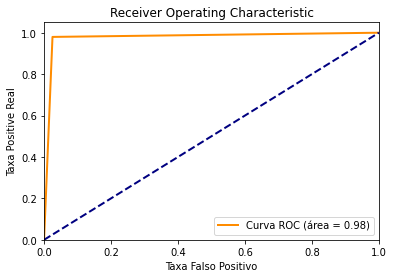

In [21]:
fpr, tpr, _ = roc_curve(lista_classes_verdadeiras, lista_previsoes)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa Falso Positivo')
plt.ylabel('Taxa Positive Real')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Gráfico da Acurácia

In [22]:
print(accuracy_score(lista_classes_verdadeiras, lista_previsoes))

0.9774542038515736


### Matriz de confusão

[[1939   50]
 [  46 2223]]


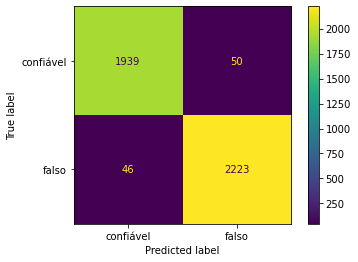

In [23]:
conf = confusion_matrix(lista_classes_verdadeiras, lista_previsoes)
print(conf)
cmd = ConfusionMatrixDisplay(conf, display_labels=['confiável','falso'])
cmd.plot()

### Gera as estatísticas do treino

In [24]:
# Cria um dataframe das estatísticas
pd.set_option('precision', 2)
df_estatisticas = pd.DataFrame(data=estatisticas)
df_estatisticas = df_estatisticas.set_index('epoca')

### Curva de aprendizado

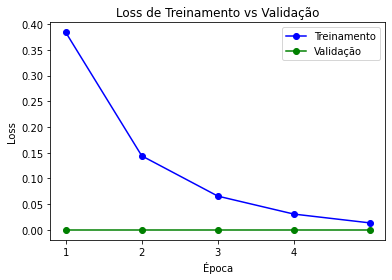

In [25]:
plt.figure()
# Mostra curva de aprendizado.
plt.plot(df_estatisticas['Loss de Treinamento'], 'b-o', label="Treinamento")
plt.plot(df_estatisticas['Loss de Validação'], 'g-o', label="Validação")
plt.title("Loss de Treinamento vs Validação")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])
plt.show()

### Acurácia

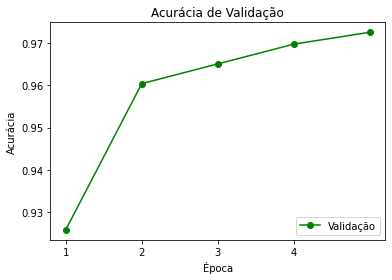

In [26]:
plt.figure()
plt.plot(df_estatisticas['Acurácia de Validação'], 'g-o', label="Validação")
plt.title("Acurácia de Validação")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend(loc="lower right")
plt.xticks([1, 2, 3, 4])
plt.show()

### Salvando o melhor modelo

In [27]:
CAMINHO_MODELO = "drive/MyDrive/PUC/TCC/modelos/bertimbau_avaliar_noticias_whatsapp"
model.save_pretrained(f"{CAMINHO_MODELO}")
tokenizer.save_pretrained(f"{CAMINHO_MODELO}")

('drive/MyDrive/PUC/TCC/modelos/bertimbau_avaliar_noticias_whatsapp/tokenizer_config.json',
 'drive/MyDrive/PUC/TCC/modelos/bertimbau_avaliar_noticias_whatsapp/special_tokens_map.json',
 'drive/MyDrive/PUC/TCC/modelos/bertimbau_avaliar_noticias_whatsapp/vocab.txt',
 'drive/MyDrive/PUC/TCC/modelos/bertimbau_avaliar_noticias_whatsapp/added_tokens.json')